In [1]:
from tqdm import tqdm
import pandas_datareader as web
import pandas as pd
import datetime as dt
import numpy as np
from scipy.optimize import minimize
import pyfolio as pf
import warnings
import yfinance as yf
import matplotlib.pyplot as plt
import empyrical
from ta import momentum 
from ta import trend
from ta import volatility
from ta import volume
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta 
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
import investpy
from datetime import datetime, timedelta, date
from arch import arch_model
plt.style.use('seaborn')
print(datetime.now())

from alpha_vantage.timeseries import TimeSeries
api_alpha_vantage = 'TVVU975Z2WVV7791'
ts = TimeSeries(key = api_alpha_vantage, output_format= 'pandas')
import time
import seaborn as sns

from hurst import compute_Hc, random_walk
hurst = lambda x: compute_Hc(x)[0]

import math
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

C:\Users\felip\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


2023-08-30 15:49:48.907608


<ipython-input-1-20034bd790ac>:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
warnings.filterwarnings('ignore')
yf.pdr_override()

#%% Inputs

#Restrições
bound = (0.0, .3)
rent_alvo = np.arange(-1.00, 1, 0.01)

#Data
first_price_date = dt.datetime(2014, 1, 1)
if date.today().day > 27: #No final do mês ele considera o mês como finalizado
    last_price_date = dt.datetime(2023, date.today().month + 1, 1)
else:
    last_price_date = dt.datetime(2023, date.today().month, 1)


symbols = ['PETR4.SA', 'AMER3.SA', 'ITUB4.SA','VALE3.SA','WEGE3.SA','ELET3.SA','B3SA3.SA',\
           'VIIA3.SA','COGN3.SA','OIBR3.SA','CIEL3.SA','SHOW3.SA','EMBR3.SA','CVCB3.SA',\
           'ALPA4.SA','ABEV3.SA', 'BPAN4.SA','BBSE3.SA','BBDC4.SA','BBAS3.SA',\
           'BRKM5.SA','BRFS3.SA','CCRO3.SA','CMIG4.SA','CPLE6.SA','CSAN3.SA','CPFE3.SA','CYRE3.SA',\
           'ECOR3.SA','ENEV3.SA','EGIE3.SA','EQTL3.SA','EZTC3.SA','FLRY3.SA',\
           'GGBR4.SA','GOLL4.SA','HYPE3.SA','JBSS3.SA','JHSF3.SA',\
           'KLBN11.SA',\
           'LREN3.SA','MGLU3.SA','MRFG3.SA','BEEF3.SA','MRVE3.SA','MULT3.SA','PRIO3.SA','QUAL3.SA',\
           'RADL3.SA',\
           #'RAIL3.SA',\
           'SBSP3.SA','SANB11.SA','SLCE3.SA','TAEE11.SA','VIVT3.SA',\
           'TIMS3.SA','TOTS3.SA','USIM5.SA','YDUQ3.SA']

benchmarks = ['^BVSP']

preselection = 'yes'

ml_method = 'RF'

opt_method = '1/N'

trainning_test_size = 'yearly'

test_size = 'monthly'

data_source = 'yf'

In [3]:
#%% Download
data = pd.DataFrame()
data_high = pd.DataFrame()
data_low = pd.DataFrame()
data_volume = pd.DataFrame()
data_benchmark = pd.DataFrame()

#Baixando os dados
#Várias formas de puxar os dados 
if data_source == 'excel':
    data =\
    pd.read_excel('data.xlsx').set_index('date').fillna(method='bfill').loc[first_price_date:]
    data_high = \
    pd.read_excel('data_high.xlsx').set_index('date').fillna(method='bfill').loc[first_price_date:]
    data_low =\
    pd.read_excel('data_low.xlsx').set_index('date').fillna(method='bfill').loc[first_price_date:]
    data_volume =\
    pd.read_excel('data_volume.xlsx').set_index('date').fillna(method='bfill').loc[first_price_date:]
else:
    for sym in tqdm(symbols):
        if data_source == 'yf':
            if sym[-3:]!='.SA':
                if sym=='BM&FBOVESPA Real Estate IFIX':
                    dados=investpy.get_index_historical_data(sym, country='brazil',\
                    from_date=first_price_date.strftime('%d/%m/%Y'),\
                    to_date=last_price_date.strftime('%d/%m/%Y')).rename(columns={'Close':'Adj Close'})
                elif sym=='Fundo de Invest Ishares SP 500':
                    dados=investpy.get_etf_historical_data(sym, country='brazil',\
                    from_date=first_price_date.strftime('%d/%m/%Y'),\
                    to_date=last_price_date.strftime('%d/%m/%Y')).rename(columns={'Close':'Adj Close'})
            else:
                dados=web.data.get_data_yahoo(sym,first_price_date,last_price_date)
            adj = dados['Adj Close']/dados['Close'] #Ajustar dados
            
        elif data_source == 'alpha':
            try:
                dados, meta_dados = ts.get_daily_adjusted(symbol = sym + 'O', outputsize = 'full')
                dados = dados.sort_index()
                dados.rename(columns={'1. open':'Open'}, inplace = True)
                dados.rename(columns={'2. high':'High'}, inplace = True)
                dados.rename(columns={'3. low':'Low'}, inplace = True)
                dados.rename(columns={'4. close':'Close'}, inplace = True)
                dados.rename(columns={'5. adjusted close':'Adj Close'}, inplace = True)
                dados.rename(columns={'6. volume':'Volume'}, inplace = True)
                dados.drop(['7. dividend amount', '8. split coefficient'], axis=1, inplace = True)
            except ValueError:
                time.sleep(60)
                dados, meta_dados = ts.get_daily_adjusted(symbol = sym + 'O', outputsize = 'full')
                dados = dados.sort_index()
                dados.rename(columns={'1. open':'Open'}, inplace = True)
                dados.rename(columns={'2. high':'High'}, inplace = True)
                dados.rename(columns={'3. low':'Low'}, inplace = True)
                dados.rename(columns={'4. close':'Close'}, inplace = True)
                dados.rename(columns={'5. adjusted close':'Adj Close'}, inplace = True)
                dados.rename(columns={'6. volume':'Volume'}, inplace = True)
                dados.drop(['7. dividend amount', '8. split coefficient'], axis=1, inplace = True)     
            adj = 1 #Dados já ajustados

        dados = dados.loc[first_price_date:last_price_date]
        data[sym] = dados['Adj Close']
        data_high[sym] = dados['High']*adj
        data_low[sym] = dados['Low']*adj
        data_volume[sym] = dados['Volume']

data_total = data
data = data.fillna(method = 'ffill')
data_high = data_high.fillna(method = 'ffill')
data_low = data_low.fillna(method = 'ffill')
data_volume = data_volume.fillna(method = 'ffill')

data_benchmark = pd.DataFrame()

returns = np.log(data / data.shift(1)) 
returns = returns.dropna()

#Baixando os benchmarks
for benchmark in benchmarks:
    data_benchmark[benchmark] = \
    web.data.get_data_yahoo(benchmark,first_price_date,last_price_date)['Adj Close']
data_benchmark = data_benchmark.dropna()

returns_benchmark = np.log(data_benchmark / data_benchmark.shift(1)) 
returns_benchmark = returns_benchmark.dropna()

  0%|          | 0/58 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed

  2%|▏         | 1/58 [00:00<00:48,  1.18it/s]


[*********************100%***********************]  1 of 1 completed

  3%|▎         | 2/58 [00:01<00:45,  1.23it/s]


[*********************100%***********************]  1 of 1 completed

  5%|▌         | 3/58 [00:02<00:41,  1.34it/s]


[*********************100%***********************]  1 of 1 completed

  7%|▋         | 4/58 [00:02<00:36,  1.47it/s]


[*********************100%***********************]  1 of 1 completed

  9%|▊         | 5/58 [00:03<00:34,  1.55it/s]


[*********************100%***********************]  1 of 1 completed

 10%|█         | 6/58 [00:03<00:32,  1.60it/s]


[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 7/58 [00:04<00:31,  1.64it/s]


[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 8/58 [00:05<00:32,  1.53it/s]


[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 9/58 [00:05<00:30,  1.60it/s]


[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 10/58 [00:06<00:25,  1.86it/s]


[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 11/58 [00:06<00:22,  2.12it/s]


[*********************100%***********************]  1 of 1 completed

 21%|██        | 12/58 [00:06<00:22,  2.05it/s]


[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 13/58 [00:07<00:22,  1.98it/s]


[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 14/58 [00:07<00:22,  1.95it/s]


[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 15/58 [00:08<00:22,  1.90it/s]


[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 16/58 [00:09<00:22,  1.90it/s]


[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 17/58 [00:09<00:22,  1.83it/s]


[*********************100%***********************]  1 of 1 completed

 31%|███       | 18/58 [00:10<00:22,  1.76it/s]


[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 19/58 [00:10<00:23,  1.63it/s]


[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 20/58 [00:11<00:22,  1.68it/s]


[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 21/58 [00:11<00:19,  1.88it/s]


[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 22/58 [00:12<00:17,  2.08it/s]


[*********************100%***********************]  1 of 1 completed

 40%|███▉      | 23/58 [00:12<00:17,  1.99it/s]


[*********************100%***********************]  1 of 1 completed

 41%|████▏     | 24/58 [00:13<00:18,  1.88it/s]


[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 25/58 [00:14<00:19,  1.73it/s]


[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 26/58 [00:14<00:17,  1.87it/s]


[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 27/58 [00:15<00:16,  1.85it/s]


[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 28/58 [00:15<00:16,  1.80it/s]


[*********************100%***********************]  1 of 1 completed

 50%|█████     | 29/58 [00:16<00:17,  1.66it/s]


[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 30/58 [00:16<00:16,  1.73it/s]


[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 31/58 [00:17<00:15,  1.76it/s]


[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 32/58 [00:18<00:14,  1.77it/s]


[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 33/58 [00:18<00:14,  1.76it/s]


[*********************100%***********************]  1 of 1 completed

 59%|█████▊    | 34/58 [00:19<00:13,  1.77it/s]


[*********************100%***********************]  1 of 1 completed

 60%|██████    | 35/58 [00:19<00:13,  1.76it/s]


[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 36/58 [00:20<00:12,  1.79it/s]


[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 37/58 [00:20<00:12,  1.74it/s]


[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 38/58 [00:21<00:11,  1.77it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 39/58 [00:22<00:12,  1.53it/s]


[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 40/58 [00:22<00:11,  1.55it/s]


[*********************100%***********************]  1 of 1 completed

 71%|███████   | 41/58 [00:23<00:11,  1.46it/s]


[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 42/58 [00:24<00:09,  1.71it/s]


[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 43/58 [00:24<00:08,  1.75it/s]


[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 44/58 [00:25<00:07,  1.78it/s]


[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 45/58 [00:25<00:07,  1.81it/s]


[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 46/58 [00:26<00:06,  1.82it/s]


[*********************100%***********************]  1 of 1 completed

 81%|████████  | 47/58 [00:26<00:05,  1.86it/s]


[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 48/58 [00:27<00:05,  1.98it/s]


[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 49/58 [00:27<00:04,  1.91it/s]


[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 50/58 [00:28<00:04,  1.65it/s]


[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 51/58 [00:28<00:03,  1.77it/s]


[*********************100%***********************]  1 of 1 completed

 90%|████████▉ | 52/58 [00:29<00:03,  1.80it/s]


[*********************100%***********************]  1 of 1 completed

 91%|█████████▏| 53/58 [00:30<00:02,  1.83it/s]


[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 54/58 [00:30<00:02,  1.82it/s]


[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 55/58 [00:31<00:01,  1.82it/s]


[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 56/58 [00:31<00:01,  1.74it/s]


[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 57/58 [00:32<00:00,  1.74it/s]


[*********************100%***********************]  1 of 1 completed

100%|██████████| 58/58 [00:32<00:00,  1.76it/s]

[*********************100%***********************]  1 of 1 completed


In [4]:
#%% Optimization 

### Markowitz with preselection ###
#if preselection == 'yes':
    
def portfolio_variance_ps(w): #matriz de covariância
    _w = np.asarray(w) #tirar o "_"
    return _w.dot(covariance_matrix).dot(_w)

def portfolio_return_ps(w):
    _w = np.asarray(w)
    return _w.dot(annualized_returns)

def portfolio_variance_gradient_ps(w):
    _w = np.asarray(w)
    return 2 * _w.dot(covariance_matrix)

def minimize_portfolio_variance_ps(min_return):
    assets_number = len(winners_list)
    bnds = [bound for i in range(assets_number)] 
    initial_guess = [1 / assets_number for i in range(assets_number)]
    cons = ({'type': 'eq', 'fun': lambda w: w.sum() - 1},
            {'type': 'ineq', 'fun': lambda w: portfolio_return_ps(w) - min_return})
    return minimize(portfolio_variance_ps, initial_guess,
                    constraints=cons,
                    bounds=bnds,
                    options={'disp': False},
                    method='SLSQP',
                    jac=portfolio_variance_gradient_ps)

def calculate_mv_frontier_ps():
    frontier = pd.Series()
    weights = pd.DataFrame()
    for min_return in rent_alvo:
        result = minimize_portfolio_variance_ps(min_return)
        if not result.success:
            continue
        w_frontier = result.x
        port_sigma = np.sqrt(portfolio_variance_ps(w_frontier))
        port_return = portfolio_return_ps(w_frontier)
        frontier.at[port_sigma] = port_return

        for i, win in enumerate(winners_list):
            weights.at[round(port_sigma,2), win] = round(w_frontier[i],4)
            
    return frontier, weights

### Markowitz MV ###

def portfolio_variance(w):
    _w = np.asarray(w) #tirar o "_"
    return _w.dot(covariance_matrix).dot(_w)

def portfolio_return(w):
    _w = np.asarray(w)
    return _w.dot(annualized_returns)

def portfolio_variance_gradient(w):
    _w = np.asarray(w)
    return 2 * _w.dot(covariance_matrix)

def minimize_portfolio_variance(min_return):
    assets_number = len(symbols)
    bnds = [bound for i in range(assets_number)] 
    initial_guess = [1 / assets_number for i in range(assets_number)]
    cons = ({'type': 'eq', 'fun': lambda w: w.sum() - 1},
            {'type': 'ineq', 'fun': lambda w: portfolio_return(w) - min_return})
    return minimize(portfolio_variance, initial_guess,
                    constraints=cons,
                    bounds=bnds,
                    options={'disp': False},
                    method='SLSQP',
                    jac=portfolio_variance_gradient)

def calculate_mv_frontier():
    frontier = pd.Series()
    weights = pd.DataFrame()
    for min_return in rent_alvo:
        result = minimize_portfolio_variance_ps(min_return)
        if not result.success:
            continue
        w_frontier = result.x
        port_sigma = np.sqrt(portfolio_variance_ps(w_frontier))
        port_return = portfolio_return_ps(w_frontier)
        frontier.at[port_sigma] = port_return

        for i, symbol in enumerate(symbols):
            weights.at[round(port_sigma,2), symbol] = round(w_frontier[i],4)
            
    return frontier, weights


### Hierarchical Risk Parity (HRP) ###
def calculate_hrp(returns_escolhido):
    hrp = hierarchical_risk_parity.HRPOpt(returns_escolhido)
    a=hrp.hrp_portfolio()
    a=pd.Series(a)
    a = pd.DataFrame(a)
    weights = a.T
    return weights

### 1/N ###

def calculate_ns():
    weights = pd.DataFrame(columns=symbols, index = [0])
    for sym in symbols:
        weights[sym][0] = 1.0/len(symbols)  

    return weights   

#Calculando o retorno acumulado
def portfolio_performance(initial_data_slc, end_data_slc):    
    portfolio = weights.iloc[0]
    sliced_returns = returns.loc[initial_data_slc:end_data_slc]
    retorno_ponderado = (portfolio * sliced_returns)
    retorno = retorno_ponderado.sum(axis=1)
    retorno_acumulado = (retorno+1).cumprod()
            
    return retorno, retorno_acumulado, portfolio 

def garch(serie_dados, periodos):
    
    ativo_slice=serie_dados
    retorno=np.log(ativo_slice/ativo_slice.shift(1)).dropna()
    padronizado=(retorno-retorno.mean())/retorno.std()
    
    garch_model=arch_model(retorno, p=1, q=1, vol='GARCH', dist='Normal', rescale=False)
    resultados=garch_model.fit(disp='off')
    parametros=resultados.params
    
    gama=1-parametros['alpha[1]']-parametros['beta[1]']
    vol_incondicional=retorno.std()*(252**.5)
    vol_longo_prazo=(252*parametros['omega']/gama)**.5
    
    serie_garch=pd.Series(index=retorno.index)
    serie_garch.iloc[0]=retorno.iloc[0]**2
    for i in retorno.index[1:]:
        #print(i)
        serie_garch.loc[i]=parametros['omega']+parametros['alpha[1]']*(retorno.shift(1).loc[i]**2)+\
        parametros['beta[1]']*serie_garch.shift(1).loc[i]
            
    return ((resultados.forecast(horizon=periodos, reindex=False).variance.iloc[0])*252)**.5,\
           (serie_garch*252)**.5

def portfolio_results(ativos, pesos, data_ini):
    
    returns_mes=pd.DataFrame()

    for i in ativos:
        returns_mes[i]=\
        web.data.get_data_yahoo(i,data_ini,datetime(2099,12,31).date())['Adj Close']

    returns_mes=(returns_mes/returns_mes.shift(1)).fillna(1)
    returns_portfolio=np.dot(returns_mes.cumprod(),pesos)

    benchmark_mes=\
    web.data.get_data_yahoo(benchmark,data_ini,datetime(2099,12,31).date())['Adj Close']
    ret_benchmark_mes=(benchmark_mes/benchmark_mes.shift(1)).fillna(1).cumprod()

    comparative=pd.DataFrame(index=ret_benchmark_mes.index)
    comparative.loc[:,'Strategy']=returns_portfolio
    comparative.loc[:,'Benchmark']=ret_benchmark_mes.values

    return comparative

def prints_returns():
    print('Strategy')
    print('Retorno: ',\
    round(np.log(returns_portfolio/returns_portfolio.shift(1))['Strategy'].dropna().mean()*252*100,2))
    print('Vol: ',\
    round(np.log(returns_portfolio/returns_portfolio.shift(1))['Strategy'].dropna().std()*(252**.5)*100,2))
    print('------------------')
    print('Benchmark')
    print('Retorno:',\
    round(np.log(returns_portfolio/returns_portfolio.shift(1))['Benchmark'].dropna().mean()*252*100,2))
    print('Vol:',\
    round(np.log(returns_portfolio/returns_portfolio.shift(1))['Benchmark'].dropna().std()*(252**.5),2))
    
def normalizar(df):
    return df/df.iloc[0]

def cf_analysis(cm):
    
    t=cm.iloc[0,0]+cm.iloc[0,1]+cm.iloc[1,0]+cm.iloc[1,1]
    acc_pos=cm.iloc[0,0]/(cm.iloc[0,0]+cm.iloc[0,1])
    tot_pos=(cm.iloc[0,0]+cm.iloc[1,1])/t
    acc_neg=cm.iloc[1,0]/(cm.iloc[1,0]+cm.iloc[1,1])
    tot_neg=(cm.iloc[0,1]+cm.iloc[1,0])/t
    acc_geral =(cm.iloc[0,0]+cm.iloc[1,0])/t
    
    print('')
    print('Acc Positive:',round(acc_pos,3),'x Tot Positive:',round(tot_pos,3))
    print('Acc Negative:',round(acc_neg,3),'x Tot Negative:',round(tot_neg,3))
    print('Acc Geral:',round(acc_geral,3))
    
    return 0

def MAPE(y_true, y_predict): 
    y_true, y_predict = np.array(y_true), np.array(y_predict)
    return np.mean(np.abs((y_true - y_predict) / y_true)) * 100

def analise_rrg(serie, n_days):
    #ratio entre as ações
    ratio=(100*serie)
    #macd do ratio
    macd=trend.MACD(ratio,30,10,9).macd()
    #eixo x do rrg
    eixo_x=100*(macd/ratio)
    #ema do eixo_x
    ema=trend.EMAIndicator(eixo_x, 9).ema_indicator()
    #eixo y do rrg
    eixo_y=eixo_x-ema
    
    posicao=(eixo_x,eixo_y)
    posicao_past=(eixo_x.shift(n_days), eixo_y.shift(n_days))
           
    dx = eixo_x - eixo_x.shift(n_days)
    dy = eixo_y - eixo_y.shift(n_days)
    
    posicao_pred = (eixo_x + dx, eixo_y + dy)
            
    intensidade=(dx**2+dy**2)**.5
    
    return posicao, posicao_past, posicao_pred, intensidade

In [5]:
data = data.fillna(method = 'bfill')
data_high = data_high.fillna(method = 'bfill')
data_low = data_low.fillna(method = 'bfill')
data_volume = data_volume.fillna(method = 'bfill')

In [6]:
#%% Run

#Returns Series
strategy_return = pd.Series()
bench_return = pd.Series()
naive_return = pd.Series()
looser_return = pd.Series()

#Listas para avaliar acurácia e criar matriz de confusão
predicted_values = []
actual_values = []
total_confusion_matrix = pd.DataFrame(0, index=['P','N'], columns=['T','F'])

#Listas para calcular indicadores de precisão das previsões
mse=[]
mape=[]
r_mean=[]

#Rankeando as winners/loosers para compará-las
selected_rank_winners = []
selected_rank_loosers = []

#Criando incremento das iterações
if test_size == 'monthly':
    increment = relativedelta(months=1)
elif test_size == 'quarterly':
    increment = relativedelta(months=3)
elif test_size == 'semesterly':
    increment = relativedelta(months=6)
elif test_size == 'yearly':
    increment = relativedelta(months=12)

#Criando incremento para determinar base de treino inicial
if trainning_test_size == 'monthly':
    increment_train = relativedelta(months=0)
elif trainning_test_size == 'quarterly':
    increment_train = relativedelta(months=2)
elif trainning_test_size == 'semesterly':
    increment_train = relativedelta(months=5)
elif trainning_test_size == 'yearly':
    increment_train = relativedelta(months=11)

#Data inicial do modelo
initial_data = first_price_date
#Iniciar variável da data limite de treino 
dat_aux = first_price_date + increment_train #auxiliar para iniciar o end_data
end_data = \
returns[(returns.index.year == dat_aux.year) &\
        (returns.index.month == dat_aux.month)].index[-1]
    
while end_data + increment <  last_price_date:
    
    if len(strategy_return) == 0: #se for a primeira iteração entra aqui
        #data final de teste
        dat_aux = first_price_date + increment_train + increment
        end_data = returns[(returns.index.year==dat_aux.year) &\
                           (returns.index.month==dat_aux.month)].index[-1]
        #data final treino
        dat_aux = end_data - increment
        limit_train_data=\
        returns[(returns.index.year == dat_aux.year) &\
                (returns.index.month == dat_aux.month)].index[-1]
        
    else:
        #Nova data limite de treino
        limit_train_data = end_data
        #Nova data inicial
        dat_aux = initial_data + increment
        initial_data=returns[(returns.index.year == dat_aux.year) &\
                             (returns.index.month == dat_aux.month)].index[0] 
        #Nova data limite de teste
        dat_aux = end_data + increment
        end_data = returns[(returns.index.year == dat_aux.year) &\
                           (returns.index.month==dat_aux.month)].index[-1]
            
    #Determinando o tamanho da base de teste (tamanho total - tamanho de treino)
    size_test = len(returns.loc[initial_data:end_data])-\
                len(returns.loc[initial_data:limit_train_data])
    
    #Determinando o início da base de teste
    initial_test_data = returns.loc[initial_data:end_data].iloc[-size_test:].index[0]
        
    #Printar datas chave
    print('------------------------------------------------------')
    print('Início Treino: ', initial_data)
    print('Fim Treino:    ', limit_train_data)
    print('Início Teste:  ', initial_test_data)
    print('Fim Teste:     ', end_data)
        
    #Dataframe que consolida valores previstos
    prediction_consolidate = pd.DataFrame(columns = symbols)
        
    #Criar Matriz de Confusão
    confusion_matrix=pd.DataFrame(0, index=['P','N'], columns=['T','F'])
    
    for sym in symbols:
        #Slicing Database
        all_data = normalizar(data.loc[initial_data-increment:end_data])
        all_data_high = normalizar(data_high.loc[initial_data-increment:end_data])
        all_data_low = normalizar(data_low.loc[initial_data-increment:end_data])
        all_data_volume = data_volume.loc[initial_data-increment:end_data]
            
        #Creating the features dataframe
        df = pd.DataFrame()
        df['RSI'] = momentum.RSIIndicator(close=all_data[sym]).rsi()
        df['ATR'] = volatility.AverageTrueRange(high=all_data_high[sym], low=all_data_low[sym],\
                                                close=all_data[sym]).average_true_range()
        df['OBV'] = volume.on_balance_volume(close=all_data[sym], volume=all_data_volume[sym])
        df['PSAR'] = trend.PSARIndicator(high=all_data_high[sym], low=all_data_low[sym],\
                                         close=all_data[sym]).psar()
            
        df['EWMA 5 P'] = pd.Series.ewm(all_data[sym], span=5).mean()
        df['EWMA 10 P'] = pd.Series.ewm(all_data[sym], span=10).mean()
        df['EWMA 22 P'] = pd.Series.ewm(all_data[sym], span=22).mean()
        df['EWMA 66 P'] = pd.Series.ewm(all_data[sym], span=66).mean()
            
        df['EWMA 5 V'] = pd.Series.ewm(all_data_volume[sym], span=5).mean()
        df['EWMA 10 V'] = pd.Series.ewm(all_data_volume[sym], span=10).mean()
        df['EWMA 22 V'] = pd.Series.ewm(all_data_volume[sym], span=22).mean()
        df['EWMA 66 V'] = pd.Series.ewm(all_data_volume[sym], span=66).mean()  
            
        #Adding simple moving average for price
        df['SMA 5 P'] = all_data[sym].rolling(5).mean()
        df['SMA 10 P'] = all_data[sym].rolling(10).mean()
        df['SMA 22 P'] = all_data[sym].rolling(22).mean()
        df['SMA 66 P'] = all_data[sym].rolling(66).mean()
            
        #Adding simple moving average for volume
        df['SMA 5 V'] = all_data_volume[sym].rolling(5).mean()
        df['SMA 10 V'] = all_data_volume[sym].rolling(10).mean()
        df['SMA 22 V'] = all_data_volume[sym].rolling(22).mean()
        df['SMA 66 V'] = all_data_volume[sym].rolling(66).mean()
            
        #Adding Momentum
        df['Momentum 5'] = all_data[sym] - all_data[sym].shift(5)
        df['Momentum 10'] = all_data[sym] - all_data[sym].shift(10)
        df['Momentum 22'] = all_data[sym] - all_data[sym].shift(22)
        df['Momentum 66'] = all_data[sym] - all_data[sym].shift(66)
            
        #Adding Rolling Std Dev of prices
        df['StdDev 5 Ret'] = all_data[sym].pct_change(1).rolling(5).std()
        df['StdDev 10 Ret'] = all_data[sym].pct_change(1).rolling(10).std()
        df['StdDev 22 Ret'] = all_data[sym].pct_change(1).rolling(22).std()
        df['StdDev 66 Ret'] = all_data[sym].pct_change(1).rolling(66).std()
            
        df['Bollinger_High_2'] = \
        volatility.BollingerBands(close = all_data[sym], window = 20, window_dev = 2)\
        .bollinger_hband() 
    
        df['Bollinger_Low_2'] = \
        volatility.BollingerBands(close = all_data[sym], window = 20, window_dev = 2)\
        .bollinger_lband() 
    
        df['Bollinger_High_1'] = \
        volatility.BollingerBands(close = all_data[sym], window = 20, window_dev = 1)\
        .bollinger_hband() 

        df['Bollinger_Low_1'] = \
        volatility.BollingerBands(close = all_data[sym], window = 20, window_dev = 1)\
        .bollinger_lband()
            
        df['MACD'] = \
        trend.MACD(close = all_data[sym], window_slow = 26, window_fast = 12, window_sign = 9)\
        .macd() 
            
        df['MACD_Signal'] = \
        trend.MACD(close = all_data[sym], window_slow = 26, window_fast = 12, window_sign = 9)\
        .macd_signal() 
            
        df['MACD_Hist'] = \
        trend.MACD(close = all_data[sym], window_slow = 26, window_fast = 12, window_sign = 9)\
        .macd_diff() 
            
        df['Ultimate Oscillator']=\
        momentum.UltimateOscillator(high = all_data_high[sym], low = all_data_low[sym],\
                                    close = all_data[sym]).ultimate_oscillator() 
            
        df['Williams']=\
        momentum.WilliamsRIndicator(high = all_data_high[sym], low = all_data_low[sym],\
        close = all_data[sym]).williams_r().replace(np.inf, 100).replace(-np.inf, -100)
            
        #Adding RRG
        df['RRG 5 X'] = analise_rrg(all_data[sym], 5)[0][0]
        df['RRG 10 X'] = analise_rrg(all_data[sym], 10)[0][0]
        df['RRG 22 X'] = analise_rrg(all_data[sym], 22)[0][0]
            
        df['RRG 5 Y'] = analise_rrg(all_data[sym], 5)[0][1]
        df['RRG 10 Y'] = analise_rrg(all_data[sym], 10)[0][1]
        df['RRG 22 Y'] = analise_rrg(all_data[sym], 22)[0][1]
            
        df['RRG 5 X Pred'] = analise_rrg(all_data[sym], 5)[2][0]
        df['RRG 10 X Pred'] = analise_rrg(all_data[sym], 10)[2][0]
        df['RRG 22 X Pred'] = analise_rrg(all_data[sym], 22)[2][0]
            
        df['RRG 5 Y Pred'] = analise_rrg(all_data[sym], 5)[2][1]
        df['RRG 10 Y Pred'] = analise_rrg(all_data[sym], 10)[2][1]
        df['RRG 22 Y Pred'] = analise_rrg(all_data[sym], 22)[2][1]
            
        df['RRG 5 Intensidade'] = analise_rrg(all_data[sym], 5)[3]
        df['RRG 10 Intensidade'] = analise_rrg(all_data[sym], 10)[3]
        df['RRG 22 Intensidade'] = analise_rrg(all_data[sym], 22)[3]
         
            
        df = df.loc[initial_data:end_data] #Slice final
        df_total = df #Salvar DataFrame 
        df = df.dropna() 
        
        #Retornos Diários
        retornos = np.log(all_data[sym]/all_data[sym].shift(1))  
        retornos = retornos.dropna()
        
        #Retornos após período de size_test dias
        retornos_periodo = np.log(all_data[sym]/all_data[sym].shift(size_test))
        retornos_periodo = retornos_periodo.dropna()
        
        #Criar modelo de normalização
        scaler = StandardScaler()
        scaler.fit(df.shift(size_test).dropna())
        
        #Criar Dataframe normalizado
        df_normalizado = scaler.transform(df.shift(size_test).dropna())
        df_normalizado = \
        pd.DataFrame(df_normalizado, index = df.shift(size_test).dropna().index, columns = df.columns)
            
        #Cria Dataframe com valores binários
        #se após um período size_test dias subiu, 1, se não, -1
        df_trend_deterministic = \
        pd.DataFrame(index = df_normalizado.index, columns = df_normalizado.columns)
        for col in df_trend_deterministic.columns:
            df_trend_deterministic.loc[:,col] = \
            np.where(df_normalizado[col].pct_change(size_test)>0, 1,-1)
            
        #Cria X_train, X_test, y_train, y_test
        X = df_trend_deterministic
        y_reg = pd.merge(df, retornos_periodo, how='inner', on = 'Date')[sym].iloc[size_test:]
        y_bin = np.where(y_reg > 0 , 1, -1)
        y_df = y_reg.copy()
        y = pd.DataFrame(y_bin, index = y_reg.index).iloc[:,0]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size_test, shuffle=False)
            
        #Determinar modelo ML
        if ml_method == 'KNN':
            model = KNeighborsClassifier(n_neighbors=5)
        if ml_method == 'RF':
            model = RandomForestClassifier(n_estimators = 100, random_state = 0)
        if ml_method == 'SVR':
            try:
                model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            except ValueError:
                model = RandomForestClassifier(n_estimators = 100, random_state = 0)
        
        #Trienar ML e prever resultados
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        #Guardar MSE, MAPE e previsão média
        mse.append(mean_squared_error(y_test+1, y_pred+1))
        mape.append(MAPE(y_test+1, y_pred+1))
        r_mean.append(y_pred.mean())

        #Registrando a previsão 
        prediction = pd.DataFrame(data=y_pred,columns=[sym])
        prediction_consolidate[sym] = prediction[sym]
            
        #creating confusion matrix     
        if prediction[sym].sum() > 0:
            if (1+retornos.loc[initial_test_data:]).cumprod().iloc[-1] > 1:
                confusion_matrix.loc['P','T'] = confusion_matrix.loc['P','T'] + 1
            else:
                confusion_matrix.loc['P','F'] = confusion_matrix.loc['P','F'] + 1
        elif prediction[sym].sum() < 1:
            if (1+retornos.loc[initial_test_data:]).cumprod().iloc[-1] < 1:
                confusion_matrix.loc['N','T'] = confusion_matrix.loc['N','T'] + 1
            else:
                confusion_matrix.loc['N','F'] = confusion_matrix.loc['N','F'] + 1
        
        #Guardar valores previstos e realizados
        predicted_values.append((prediction[sym]).iloc[-1])
        actual_values.append((retornos.loc[initial_test_data:]).cumprod().iloc[-1])
                    
    #Adicionar dados da matriz de confusão á amtriz consolidada
    total_confusion_matrix = total_confusion_matrix + confusion_matrix
            
    #Calculando o retorno acumulado
    cummulative_ret_pred = prediction_consolidate.sum()
        
    #Selecionando os ativos com retorno positivo
    winners_df = pd.DataFrame(columns=['Rent'])
    winners_df['Rent'] = cummulative_ret_pred
    total_df = winners_df.copy() #Salvar winners_df original para fazer loosers
    winners_df = winners_df.nlargest(10,'Rent')
    winners_list = list(winners_df.index)
    
    #Criar inputs da otimização
    winners_ret = returns.filter(items=winners_list, axis=1)
    winners_ret =  winners_ret.loc[y_train.index[0]:y_train.index[-1]]  
    covariance_matrix = np.asarray(252 * winners_ret.cov())
    annualized_returns = np.asarray(252 * winners_ret.mean())
        
    #Criando ranking dos retornos para ver se as escolhidas foram bem no relativo 
    ranking =\
    all_data.pct_change(size_test).iloc[-1].rank(ascending = False).loc[winners_df.index]
    selected_rank_winners.append((ranking-.5).mean())
                
    #Ponderação das carteiras       
    if preselection == 'yes':
        if opt_method == 'MV':
            frontier, weights = calculate_mv_frontier_ps()
        if opt_method == 'HRP':
            weights = calculate_hrp(winners_ret)
        if opt_method == '1/N':    
            winners_list = list(winners_ret.columns)
            weights = pd.DataFrame(columns = winners_list)
            weights.loc[0] = [1 / len(winners_list) for i in range(len(winners_list))]
    else:
        if opt_method == 'MV':
            frontier, weights = calculate_mv_frontier()
        if opt_method == 'HRP':
            weights = calculate_hrp(returns)
        if opt_method == '1/N':
            weights = calculate_ns()
        
    #Resultados da Carteira Winners
    retorno, retorno_acumulado, portfolio = portfolio_performance(initial_test_data, end_data)
    strategy_return = pd.concat([strategy_return, retorno])
        
    print('')
    print('Portfolio:')
    print(portfolio)
    print('')
    
    #Resultados do Benchmark
    benchmark_rets = returns_benchmark.loc[initial_data:end_data]
    bench_return = pd.concat([bench_return, benchmark_rets.loc[initial_test_data:end_data].squeeze()])
        
    #Criando carteira Naive
    winners_list = list(all_data.columns)
    weights = pd.DataFrame(columns = winners_list)
    weights.loc[0] = [1 / len(winners_list) for i in range(len(winners_list))]
       
    #Resultados da Carteira Naive
    retorno_naive, retorno_acumulado_naive, portfolio_naive = \
    portfolio_performance(initial_test_data,end_data)
    naive_return = pd.concat([naive_return, retorno_naive])
        
    #Criando carteira Looser
    winners_df = total_df.nsmallest(10,'Rent')
    winners_list = list(winners_df.index)    
    winners_ret = returns.filter(items=winners_list, axis=1)
    winners_ret =  winners_ret.loc[y_train.index[0]:y_train.index[-1]]
    winners_list = list(winners_ret.columns)
    weights = pd.DataFrame(columns = winners_list)
    weights.loc[0] = [1 / len(winners_list) for i in range(len(winners_list))]
    
    #Resultados da Carteira Looser
    retorno_looser, retorno_acumulado_looser, portfolio_looser =\
    portfolio_performance(y_test.index[0],y_test.index[-1])
    looser_return = pd.concat([looser_return, retorno_looser])
    
    #Criando ranking dos retornos para ver se as escolhidas foram bem no relativo
    ranking = \
    all_data.pct_change(size_test).iloc[-1].rank(ascending = False).loc[winners_df.index]
    selected_rank_loosers.append((ranking-.5).mean())
        
    #Prints e mais prints
    print('Janela Treino:         ', \
    len(returns.loc[initial_data:end_data].loc[initial_data:limit_train_data])-\
    len(returns.loc[initial_data:end_data].loc[initial_test_data:end_data]))
    print('Janela Teste:        ', \
    len(returns.loc[initial_data:end_data].loc[initial_test_data:end_data]))
    print('Retorno:              ', (retorno+1).cumprod()[-1]-1)
    print('Retorno Looser:              ', (retorno_looser+1).cumprod()[-1]-1)
    print('Retorno Benchmark:    ', \
    (benchmark_rets.loc[initial_test_data:end_data]+1).cumprod().iloc[-1].values[0]-1)
    print('Retornos Acumulados:  ',\
    (strategy_return+1).cumprod()[-1],'x',(bench_return+1).cumprod().iloc[-1], 'x',\
    (naive_return+1).cumprod().iloc[-1], 'x',(looser_return+1).cumprod().iloc[-1] )
    print('Volatilidade:         ', np.sqrt(portfolio_variance(portfolio)))
    print('Sharpe Ratio:         ', empyrical.sharpe_ratio(returns=retorno))
    print('Maximum Draw Down:    ', empyrical.max_drawdown(returns=retorno))
    print('Value at Risk:        ', empyrical.value_at_risk(returns=retorno, cutoff=0.01))
    #print('Beta:                 ',\
    #      empyrical.beta(returns=retorno, factor_returns=benchmark_rets[benchmarks])) 
    #print('------------------------------------------------------')
    print('')
    print(confusion_matrix)
    cf_analysis(confusion_matrix)
    print('')
    print(total_confusion_matrix)
    cf_analysis(total_confusion_matrix)
    print('')
    print('MSE:',round(100*sum(mse)/len(mse),3),'%')
    print('MAPE:',round(sum(mape)/len(mape),3),'%')
    print('Retorno Médio:',round(100*sum(r_mean)/len(r_mean),3),'%')
    print('Ranking Winners:',round(sum(selected_rank_winners)/len(selected_rank_winners),3))
    print('Ranking Loosers:',round(sum(selected_rank_loosers)/len(selected_rank_loosers),3))
    print('')

        
#criando incremento para nova data inicial
dat_aux = initial_data + increment
new_initial_data = returns[(returns.index.year == dat_aux.year) &\
                           (returns.index.month == dat_aux.month)].index[0] 

------------------------------------------------------
Início Treino:  2014-01-01 00:00:00
Fim Treino:     2014-12-30 00:00:00
Início Teste:   2015-01-02 00:00:00
Fim Teste:      2015-01-30 00:00:00

Portfolio:
WEGE3.SA     0.1
EMBR3.SA     0.1
KLBN11.SA    0.1
BEEF3.SA     0.1
B3SA3.SA     0.1
BBAS3.SA     0.1
BRFS3.SA     0.1
TAEE11.SA    0.1
AMER3.SA     0.1
MRVE3.SA     0.1
Name: 0, dtype: float64

Janela Treino:          211
Janela Teste:         21
Retorno:               -0.03650790356513922
Retorno Looser:               -0.09502178088260915
Retorno Benchmark:     -0.06481559819514082
Retornos Acumulados:   0.9634920964348608 x 0.9351844018048592 x 0.9084324964054002 x 0.9049782191173908
Volatilidade:          0.19688201137923694
Sharpe Ratio:          -2.354723866543187
Maximum Draw Down:     -0.05384106582228483
Value at Risk:         -0.020441679715244385

    T   F
P   8  17
N  26   7

Acc Positive: 0.32 x Tot Positive: 0.259
Acc Negative: 0.788 x Tot Negative: 0.741
Acc Gera


Portfolio:
VIIA3.SA     0.1
BRFS3.SA     0.1
EQTL3.SA     0.1
KLBN11.SA    0.1
LREN3.SA     0.1
RADL3.SA     0.1
TAEE11.SA    0.1
USIM5.SA     0.1
FLRY3.SA     0.1
SANB11.SA    0.1
Name: 0, dtype: float64

Janela Treino:          228
Janela Teste:         21
Retorno:               -0.08272933357523904
Retorno Looser:               -0.11026828424024959
Retorno Benchmark:     -0.08615905459588802
Retornos Acumulados:   0.8926381385328538 x 0.917861335621052 x 0.8365986408307591 x 0.7204820424211137
Volatilidade:          0.15622431346263627
Sharpe Ratio:          -4.981592852721051
Maximum Draw Down:     -0.112756538525487
Value at Risk:         -0.026425491786096506

    T   F
P   2  23
N  29   4

Acc Positive: 0.08 x Tot Positive: 0.103
Acc Negative: 0.879 x Tot Negative: 0.897
Acc Geral: 0.534

     T    F
P   79   87
N  173  125

Acc Positive: 0.476 x Tot Positive: 0.44
Acc Negative: 0.581 x Tot Negative: 0.56
Acc Geral: 0.543

MSE: 175.074 %
MAPE: nan %
Retorno Médio: -19.016 %
Ran


Portfolio:
ITUB4.SA     0.1
KLBN11.SA    0.1
SBSP3.SA     0.1
BRKM5.SA     0.1
CCRO3.SA     0.1
HYPE3.SA     0.1
RADL3.SA     0.1
MRFG3.SA     0.1
EMBR3.SA     0.1
MRVE3.SA     0.1
Name: 0, dtype: float64

Janela Treino:          223
Janela Teste:         22
Retorno:               0.03576362566703972
Retorno Looser:               0.21796906158486995
Retorno Benchmark:     0.16199773460648048
Retornos Acumulados:   0.9736608937824304 x 0.9613007118250517 x 0.8773194740242073 x 0.6679611857409145
Volatilidade:          0.23092417474763927
Sharpe Ratio:          2.403476126981914
Maximum Draw Down:     -0.035509572668793295
Value at Risk:         -0.02013665875850163

    T   F
P  14   5
N   6  33

Acc Positive: 0.737 x Tot Positive: 0.81
Acc Negative: 0.154 x Tot Negative: 0.19
Acc Geral: 0.345

     T    F
P  151  150
N  316  253

Acc Positive: 0.502 x Tot Positive: 0.464
Acc Negative: 0.555 x Tot Negative: 0.536
Acc Geral: 0.537

MSE: 174.056 %
MAPE: nan %
Retorno Médio: -22.305 %
Ran


Portfolio:
PETR4.SA    0.1
VALE3.SA    0.1
WEGE3.SA    0.1
ELET3.SA    0.1
COGN3.SA    0.1
SHOW3.SA    0.1
CVCB3.SA    0.1
ABEV3.SA    0.1
CMIG4.SA    0.1
CPLE6.SA    0.1
Name: 0, dtype: float64

Janela Treino:          228
Janela Teste:         20
Retorno:               0.0899498573277504
Retorno Looser:               0.08426358428937308
Retorno Benchmark:     0.11141044695444902
Retornos Acumulados:   1.2870385381405542 x 1.2290299988457534 x 1.1386714649133558 x 0.8763198335241765
Volatilidade:          0.3120619544978857
Sharpe Ratio:          7.602614300463746
Maximum Draw Down:     -0.013994892089824832
Value at Risk:         -0.011846630652741772

    T   F
P  35  12
N   2   9

Acc Positive: 0.745 x Tot Positive: 0.759
Acc Negative: 0.182 x Tot Negative: 0.241
Acc Geral: 0.638

     T    F
P  292  246
N  383  355

Acc Positive: 0.543 x Tot Positive: 0.507
Acc Negative: 0.519 x Tot Negative: 0.493
Acc Geral: 0.529

MSE: 169.981 %
MAPE: nan %
Retorno Médio: -9.073 %
Ranking Winne


Portfolio:
CVCB3.SA    0.1
CPFE3.SA    0.1
CYRE3.SA    0.1
EQTL3.SA    0.1
EZTC3.SA    0.1
HYPE3.SA    0.1
MGLU3.SA    0.1
MRVE3.SA    0.1
MULT3.SA    0.1
PRIO3.SA    0.1
Name: 0, dtype: float64

Janela Treino:          227
Janela Teste:         22
Retorno:               -0.07281876185645675
Retorno Looser:               -0.024499023044733392
Retorno Benchmark:     -0.04705482712688869
Retornos Acumulados:   1.386491110230264 x 1.1658430746027404 x 1.1723543030928745 x 1.085364172728789
Volatilidade:          0.19519620048249783
Sharpe Ratio:          -1.8513872757180663
Maximum Draw Down:     -0.1345467121603809
Value at Risk:         -0.08935131690828775

    T   F
P  11  25
N  16   6

Acc Positive: 0.306 x Tot Positive: 0.293
Acc Negative: 0.727 x Tot Negative: 0.707
Acc Geral: 0.466

     T    F
P  410  380
N  456  436

Acc Positive: 0.519 x Tot Positive: 0.503
Acc Negative: 0.511 x Tot Negative: 0.497
Acc Geral: 0.515

MSE: 174.746 %
MAPE: nan %
Retorno Médio: -1.784 %
Ranking Wi


Portfolio:
VIIA3.SA    0.1
CPFE3.SA    0.1
CYRE3.SA    0.1
ECOR3.SA    0.1
EGIE3.SA    0.1
EQTL3.SA    0.1
EZTC3.SA    0.1
JBSS3.SA    0.1
PRIO3.SA    0.1
RADL3.SA    0.1
Name: 0, dtype: float64

Janela Treino:          233
Janela Teste:         21
Retorno:               0.07651370475826536
Retorno Looser:               0.021562816283137387
Retorno Benchmark:     0.06069859061245575
Retornos Acumulados:   1.81968164660124 x 1.4109742773676954 x 1.4453427763780822 x 1.2556651834586694
Volatilidade:          0.1991874428529328
Sharpe Ratio:          6.947636820420432
Maximum Draw Down:     -0.0156535965308069
Value at Risk:         -0.01304999377728814

    T  F
P  37  6
N   6  9

Acc Positive: 0.86 x Tot Positive: 0.793
Acc Negative: 0.4 x Tot Negative: 0.207
Acc Geral: 0.741

     T    F
P  595  472
N  507  514

Acc Positive: 0.558 x Tot Positive: 0.531
Acc Negative: 0.497 x Tot Negative: 0.469
Acc Geral: 0.528

MSE: 172.791 %
MAPE: nan %
Retorno Médio: 4.374 %
Ranking Winners: 27.325


Portfolio:
AMER3.SA     0.1
MRFG3.SA     0.1
SANB11.SA    0.1
SLCE3.SA     0.1
VIIA3.SA     0.1
CVCB3.SA     0.1
MGLU3.SA     0.1
EMBR3.SA     0.1
GOLL4.SA     0.1
ABEV3.SA     0.1
Name: 0, dtype: float64

Janela Treino:          233
Janela Teste:         21
Retorno:               0.06402307499994775
Retorno Looser:               0.07208853205410626
Retorno Benchmark:     0.08747494597326733
Retornos Acumulados:   1.846241787744166 x 1.4454078473921759 x 1.363323476390313 x 1.0440757646151597
Volatilidade:          0.24817821490432204
Sharpe Ratio:          3.2693186052373426
Maximum Draw Down:     -0.04858578791875381
Value at Risk:         -0.02583108653311887

    T   F
P  16   6
N   4  32

Acc Positive: 0.727 x Tot Positive: 0.828
Acc Negative: 0.111 x Tot Negative: 0.172
Acc Geral: 0.345

     T    F
P  706  606
N  593  589

Acc Positive: 0.538 x Tot Positive: 0.519
Acc Negative: 0.502 x Tot Negative: 0.481
Acc Geral: 0.521

MSE: 172.945 %
MAPE: nan %
Retorno Médio: 6.751 %
Ranki


Portfolio:
AMER3.SA    0.1
ITUB4.SA    0.1
ELET3.SA    0.1
B3SA3.SA    0.1
CVCB3.SA    0.1
ALPA4.SA    0.1
BPAN4.SA    0.1
BBSE3.SA    0.1
BBDC4.SA    0.1
BBAS3.SA    0.1
Name: 0, dtype: float64

Janela Treino:          225
Janela Teste:         20
Retorno:               -0.007780771156205901
Retorno Looser:               0.023298540492408204
Retorno Benchmark:     -0.020312479839129427
Retornos Acumulados:   2.362836905504366 x 1.7179844577669794 x 1.6266411848095808 x 1.11594216092566
Volatilidade:          0.3058596300108966
Sharpe Ratio:          -0.24237977033890692
Maximum Draw Down:     -0.05278767875744666
Value at Risk:         -0.03191688542141355

    T   F
P  14  33
N   8   3

Acc Positive: 0.298 x Tot Positive: 0.293
Acc Negative: 0.727 x Tot Negative: 0.707
Acc Geral: 0.379

     T    F
P  805  696
N  695  704

Acc Positive: 0.536 x Tot Positive: 0.52
Acc Negative: 0.497 x Tot Negative: 0.48
Acc Geral: 0.517

MSE: 173.402 %
MAPE: nan %
Retorno Médio: 5.478 %
Ranking Winn


Portfolio:
ELET3.SA    0.1
B3SA3.SA    0.1
ALPA4.SA    0.1
BBSE3.SA    0.1
BRFS3.SA    0.1
CCRO3.SA    0.1
CPLE6.SA    0.1
CPFE3.SA    0.1
EZTC3.SA    0.1
FLRY3.SA    0.1
Name: 0, dtype: float64

Janela Treino:          223
Janela Teste:         21
Retorno:               -0.0004457224945579874
Retorno Looser:               0.018106485603915035
Retorno Benchmark:     0.03520724821648513
Retornos Acumulados:   2.823606552274258 x 1.8636349263969103 x 1.969921023931161 x 1.1498325006991428
Volatilidade:          0.20334508363676784
Sharpe Ratio:          0.05110777495159562
Maximum Draw Down:     -0.04569193348209039
Value at Risk:         -0.023233616203165136

    T   F
P  29  13
N   6  10

Acc Positive: 0.69 x Tot Positive: 0.672
Acc Negative: 0.375 x Tot Negative: 0.328
Acc Geral: 0.603

     T    F
P  971  795
N  755  785

Acc Positive: 0.55 x Tot Positive: 0.531
Acc Negative: 0.49 x Tot Negative: 0.469
Acc Geral: 0.522

MSE: 172.024 %
MAPE: nan %
Retorno Médio: 8.172 %
Ranking Winn


Portfolio:
AMER3.SA     0.1
EQTL3.SA     0.1
SLCE3.SA     0.1
TAEE11.SA    0.1
YDUQ3.SA     0.1
VIIA3.SA     0.1
ALPA4.SA     0.1
CPFE3.SA     0.1
EZTC3.SA     0.1
MGLU3.SA     0.1
Name: 0, dtype: float64

Janela Treino:          230
Janela Teste:         20
Retorno:               0.21053874064199452
Retorno Looser:               0.0741288774954838
Retorno Benchmark:     0.09282126536651791
Retornos Acumulados:   2.595753865159553 x 1.311560602185341 x 1.4456646164115328 x 0.7390391906896115
Volatilidade:          0.4999819747092071
Sharpe Ratio:          4.518110304020265
Maximum Draw Down:     -0.08492036109521092
Value at Risk:         -0.05551488258426072

    T   F
P  30   6
N   6  16

Acc Positive: 0.833 x Tot Positive: 0.793
Acc Negative: 0.273 x Tot Negative: 0.207
Acc Geral: 0.621

      T    F
P  1118  935
N   811  848

Acc Positive: 0.545 x Tot Positive: 0.53
Acc Negative: 0.489 x Tot Negative: 0.47
Acc Geral: 0.52

MSE: 171.406 %
MAPE: nan %
Retorno Médio: 11.36 %
Ranking 


Portfolio:
OIBR3.SA     0.1
ALPA4.SA     0.1
BBAS3.SA     0.1
CSAN3.SA     0.1
GGBR4.SA     0.1
MGLU3.SA     0.1
PRIO3.SA     0.1
TAEE11.SA    0.1
TOTS3.SA     0.1
VALE3.SA     0.1
Name: 0, dtype: float64

Janela Treino:          228
Janela Teste:         19
Retorno:               0.1611600444899084
Retorno Looser:               0.16104205688936135
Retorno Benchmark:     0.1560137842807059
Retornos Acumulados:   3.999244762572883 x 1.7421165632837239 x 1.8999696845235403 x 0.949047514895812
Volatilidade:          0.5745488622818287
Sharpe Ratio:          8.476903010246703
Maximum Draw Down:     -0.027695305132121237
Value at Risk:         -0.019729568668780926

    T   F
P  29   5
N   3  21

Acc Positive: 0.853 x Tot Positive: 0.862
Acc Negative: 0.125 x Tot Negative: 0.138
Acc Geral: 0.552

      T     F
P  1268  1020
N   898   932

Acc Positive: 0.554 x Tot Positive: 0.534
Acc Negative: 0.491 x Tot Negative: 0.466
Acc Geral: 0.526

MSE: 171.383 %
MAPE: nan %
Retorno Médio: 11.764 %



Portfolio:
VALE3.SA    0.1
ELET3.SA    0.1
SHOW3.SA    0.1
EMBR3.SA    0.1
ABEV3.SA    0.1
BPAN4.SA    0.1
GGBR4.SA    0.1
JBSS3.SA    0.1
SLCE3.SA    0.1
VIVT3.SA    0.1
Name: 0, dtype: float64

Janela Treino:          226
Janela Teste:         21
Retorno:               -0.00075542353021818
Retorno Looser:               0.004682891424423463
Retorno Benchmark:     0.0040751590949985594
Retornos Acumulados:   4.833047485158423 x 2.0068882494667277 x 2.149946989106721 x 1.1182572668058668
Volatilidade:          0.21895633691684138
Sharpe Ratio:          0.02838352682189708
Maximum Draw Down:     -0.05605733161191444
Value at Risk:         -0.02221803875703366

    T   F
P  13  28
N  13   4

Acc Positive: 0.317 x Tot Positive: 0.293
Acc Negative: 0.765 x Tot Negative: 0.707
Acc Geral: 0.448

      T     F
P  1396  1142
N   971  1015

Acc Positive: 0.55 x Tot Positive: 0.533
Acc Negative: 0.489 x Tot Negative: 0.467
Acc Geral: 0.523

MSE: 171.503 %
MAPE: nan %
Retorno Médio: 12.109 %
Rank


Portfolio:
JBSS3.SA    0.1
MRFG3.SA    0.1
PETR4.SA    0.1
CPLE6.SA    0.1
SBSP3.SA    0.1
EMBR3.SA    0.1
CSAN3.SA    0.1
WEGE3.SA    0.1
BRFS3.SA    0.1
CPFE3.SA    0.1
Name: 0, dtype: float64

Janela Treino:          226
Janela Teste:         21
Retorno:               0.0042679343625682264
Retorno Looser:               0.043411762977922486
Retorno Benchmark:     0.07061134376510436
Retornos Acumulados:   4.4174586911810945 x 1.7551991580253186 x 1.790057015931984 x 0.8067036612436119
Volatilidade:          0.19777367850984306
Sharpe Ratio:          0.38213274334048986
Maximum Draw Down:     -0.055350824621392576
Value at Risk:         -0.024264898837530663

    T   F
P  10   8
N  10  30

Acc Positive: 0.556 x Tot Positive: 0.69
Acc Negative: 0.25 x Tot Negative: 0.31
Acc Geral: 0.345

      T     F
P  1458  1251
N  1119  1102

Acc Positive: 0.538 x Tot Positive: 0.519
Acc Negative: 0.504 x Tot Negative: 0.481
Acc Geral: 0.523

MSE: 171.074 %
MAPE: nan %
Retorno Médio: 9.888 %
Ranki


Portfolio:
ELET3.SA     0.1
COGN3.SA     0.1
BRFS3.SA     0.1
CPFE3.SA     0.1
HYPE3.SA     0.1
CIEL3.SA     0.1
BEEF3.SA     0.1
TAEE11.SA    0.1
SHOW3.SA     0.1
CMIG4.SA     0.1
Name: 0, dtype: float64

Janela Treino:          226
Janela Teste:         23
Retorno:               0.11507624707458763
Retorno Looser:               0.026574142128447775
Retorno Benchmark:     0.059809023375261505
Retornos Acumulados:   5.029383983782342 x 1.6931553362276135 x 1.6090930098868055 x 0.6398052770421502
Volatilidade:          0.24920428076869588
Sharpe Ratio:          6.219952288286186
Maximum Draw Down:     -0.025300313937273253
Value at Risk:         -0.019093878261747858

    T   F
P  23   4
N  12  19

Acc Positive: 0.852 x Tot Positive: 0.724
Acc Negative: 0.387 x Tot Negative: 0.276
Acc Geral: 0.603

      T     F
P  1542  1336
N  1242  1216

Acc Positive: 0.536 x Tot Positive: 0.517
Acc Negative: 0.505 x Tot Negative: 0.483
Acc Geral: 0.522

MSE: 171.61 %
MAPE: nan %
Retorno Médio: 8.15


Portfolio:
BBSE3.SA    0.1
SLCE3.SA    0.1
COGN3.SA    0.1
TIMS3.SA    0.1
WEGE3.SA    0.1
GGBR4.SA    0.1
TOTS3.SA    0.1
EMBR3.SA    0.1
CYRE3.SA    0.1
PRIO3.SA    0.1
Name: 0, dtype: float64

Janela Treino:          227
Janela Teste:         23
Retorno:               -0.010382391506062572
Retorno Looser:               -0.03533559146012366
Retorno Benchmark:     -0.030616023569176032
Retornos Acumulados:   4.235817693751192 x 1.5509309531461188 x 1.2054292051022741 x 0.31391937406035575
Volatilidade:          0.2252591362000835
Sharpe Ratio:          -0.6663587871941595
Maximum Draw Down:     -0.05679919573229217
Value at Risk:         -0.019596897382028557

    T   F
P   7  13
N  25  13

Acc Positive: 0.35 x Tot Positive: 0.345
Acc Negative: 0.658 x Tot Negative: 0.655
Acc Geral: 0.552

      T     F
P  1604  1446
N  1387  1305

Acc Positive: 0.526 x Tot Positive: 0.507
Acc Negative: 0.515 x Tot Negative: 0.493
Acc Geral: 0.521

MSE: 171.645 %
MAPE: nan %
Retorno Médio: 6.926 %
Ra

In [7]:
comp = pd.DataFrame()
comp['Strategy'] = strategy_return
comp['^BVSP'] = bench_return

In [8]:
cf_analysis(total_confusion_matrix)


Acc Positive: 0.528 x Tot Positive: 0.511
Acc Negative: 0.507 x Tot Negative: 0.489
Acc Geral: 0.518


0

<Axes: >

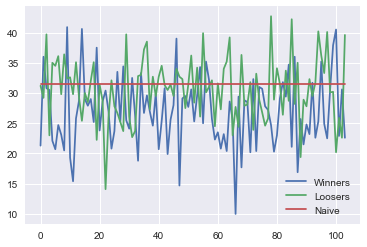

In [9]:
rankings = pd.DataFrame(index=range(len(selected_rank_winners)),\
                                       columns=['Winners', 'Loosers', 'Naive'])

rankings['Winners'] = selected_rank_winners
#comparative['Benchmark'] = bench_return
rankings['Naive'] = [31.5 for i in range(len(selected_rank_winners))]
rankings['Loosers'] = selected_rank_loosers

rankings.plot()

<Axes: >

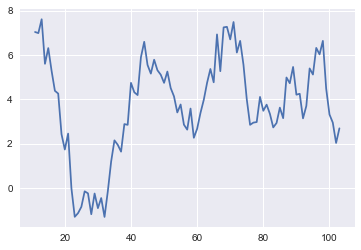

In [10]:
(rankings['Loosers'] - rankings['Winners']).rolling(12).mean().plot()

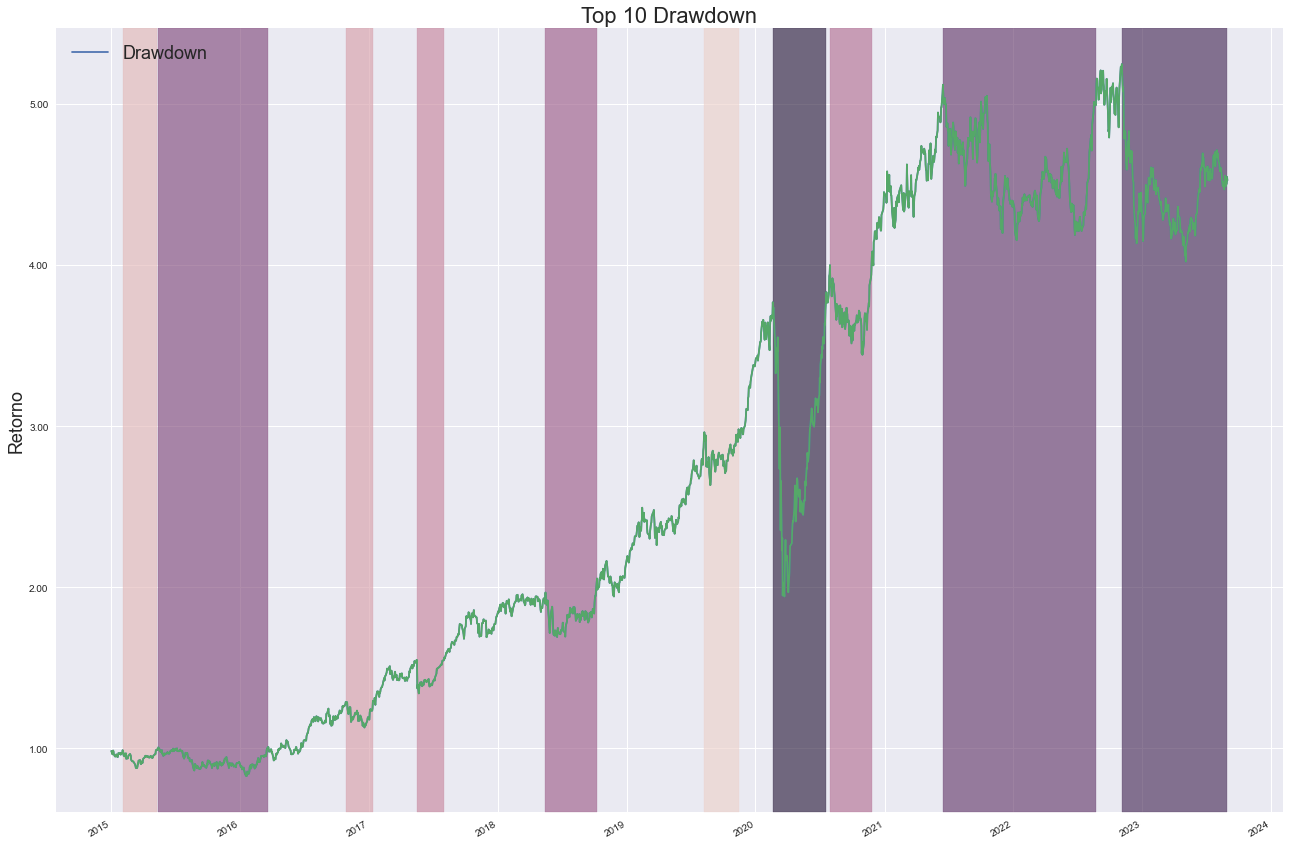

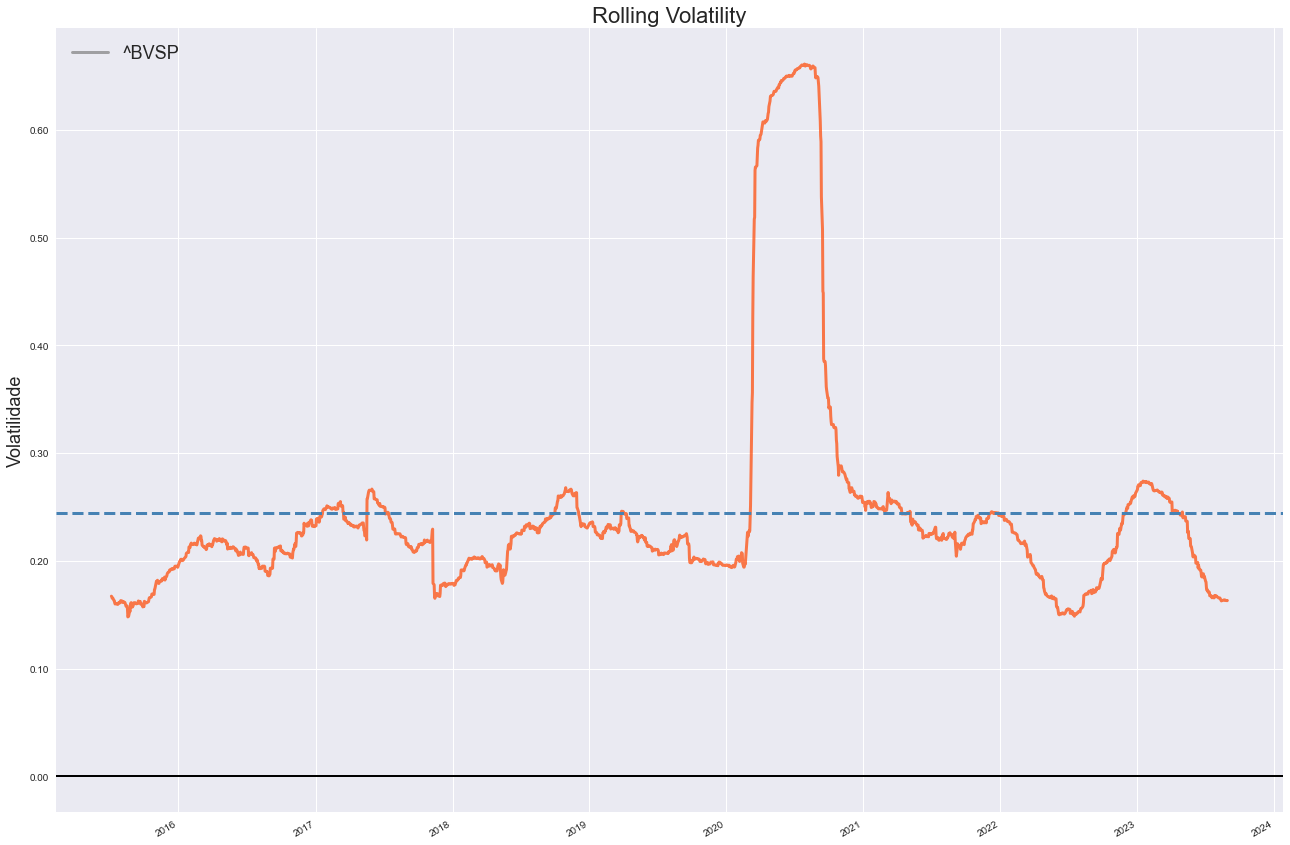

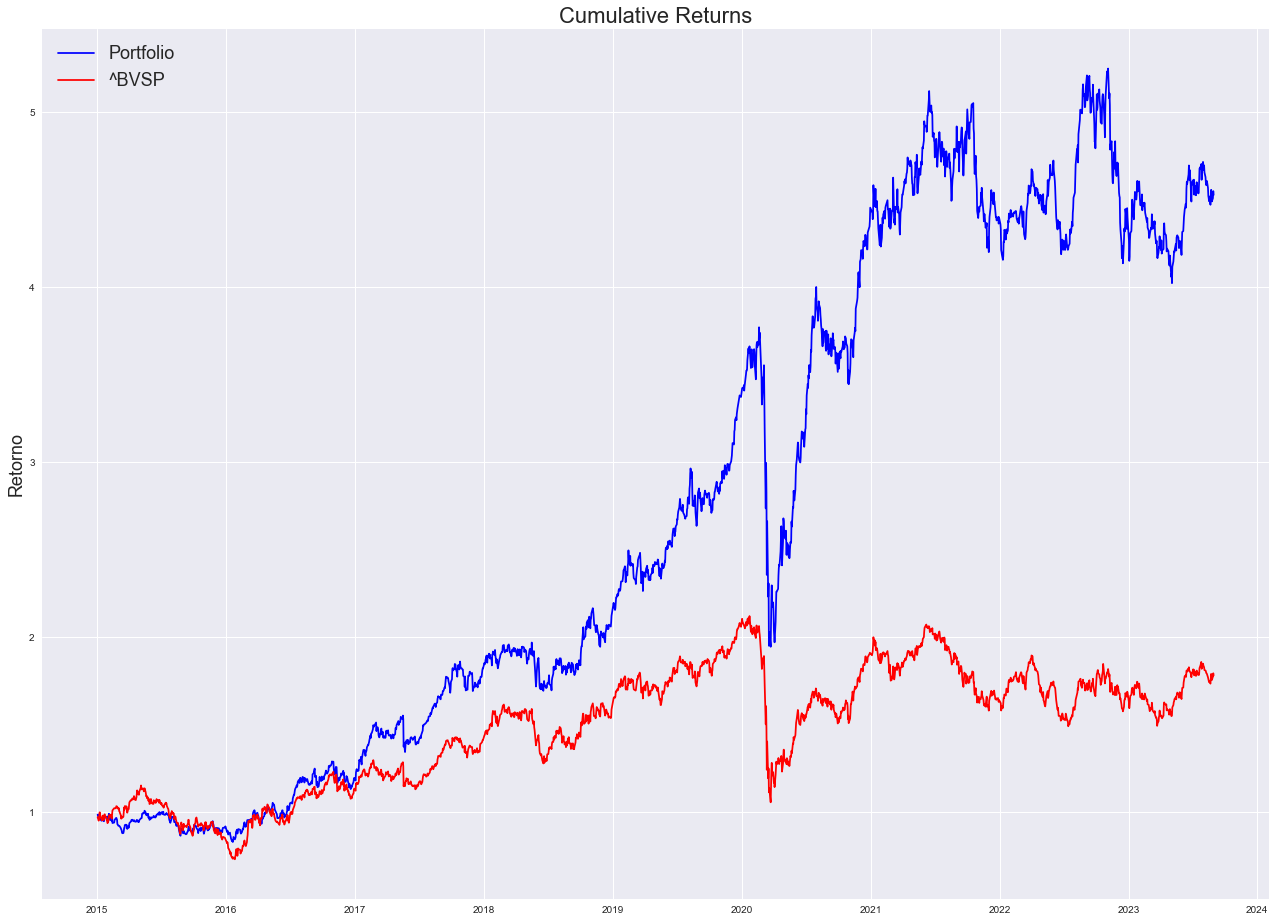

In [12]:
#Montando a planilha de resultados

analysis_sheet = pd.DataFrame(data = strategy_return)
analysis_sheet['Return'] = empyrical.annual_return(returns=strategy_return)
analysis_sheet['Volatility'] = empyrical.annual_volatility(returns=strategy_return)
analysis_sheet['Sharpe Ratio'] = empyrical.sharpe_ratio(returns=strategy_return)
analysis_sheet['Max DD'] = empyrical.max_drawdown(returns=strategy_return)
analysis_sheet['CVaR'] = empyrical.stats.conditional_value_at_risk(returns=strategy_return, cutoff= 0.05)
#analysis_sheet['Beta'] = empyrical.beta(returns=retorno, factor_returns=benchmark_rets['^BVSP'])
analysis_sheet['retorno ac.'] = (strategy_return+1).cumprod()
#analysis_sheet['N ativos médio'] = np.mean(n_ativos)
  
#analysis_sheet.to_excel('Resultados/BR/'+ml_method + '-' + opt_method + '-' + \
#trainning_test_size + '-' + test_size + '_'+data_source+'.xlsx', index = True)


#%% Graphs
#Drawdown
fig, ax1 = plt.subplots(figsize=(22,16))
drawdown_fig=pf.plot_drawdown_periods(returns=strategy_return, label= 'Drawdown')
drawdown_fig=pf.plot_drawdown_periods(returns=strategy_return)
plt.title('Top 10 Drawdown', fontsize=22)
plt.ylabel('Retorno', fontsize=18)
plt.legend(fontsize=18, loc=2)
drawdown_fig.figure.savefig('Drawdown.png', format = 'png')
    
#Volatility
fig, ax1 = plt.subplots(figsize=(22,16))
rolling_volatility_fig=pf.plot_rolling_volatility(returns=strategy_return,\
                    factor_returns=returns_benchmark['^BVSP'][retorno.index[0]:retorno.index[-1]])
plt.title('Rolling Volatility', fontsize=22)
plt.ylabel('Volatilidade', fontsize=18)
plt.legend(fontsize=18, loc=2)
rolling_volatility_fig.figure.savefig('Rolling Volatility.png', format = 'png')
    
#Cumulative Returns
fig, ax1 = plt.subplots(figsize=(22,16))
plt.plot((1+strategy_return).cumprod(), 'b', label='Portfolio')
plt.plot((1+returns_benchmark['^BVSP'][strategy_return.index[0]:strategy_return.index[-1]]).cumprod(),\
         'r', label='^BVSP')
plt.title('Cumulative Returns', fontsize=22)
plt.ylabel('Retorno', fontsize=18)
plt.legend(fontsize=18, loc=2)
fig.savefig('Retorno Acumulado.png', format = 'png')

Start date,2015-01-02
End date,2023-08-30
Total months,102
,Backtest
Annual return,19.3%
Cumulative returns,352.7%
Annual volatility,26.1%
Sharpe ratio,0.81
Calmar ratio,0.40
Stability,0.94
Max drawdown,-48.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,48.44,2020-02-19,2020-03-23,2020-07-20,109
1,23.37,2022-11-04,2023-05-04,NaT,NaN
2,18.84,2021-06-15,2022-01-10,2022-08-24,312
3,17.77,2015-05-15,2016-01-20,2016-03-21,222
4,14.02,2018-05-16,2018-06-18,2018-10-08,104


Stress Events,mean,min,max
Fall2015,-0.04%,-2.84%,3.12%
New Normal,0.08%,-16.62%,13.00%


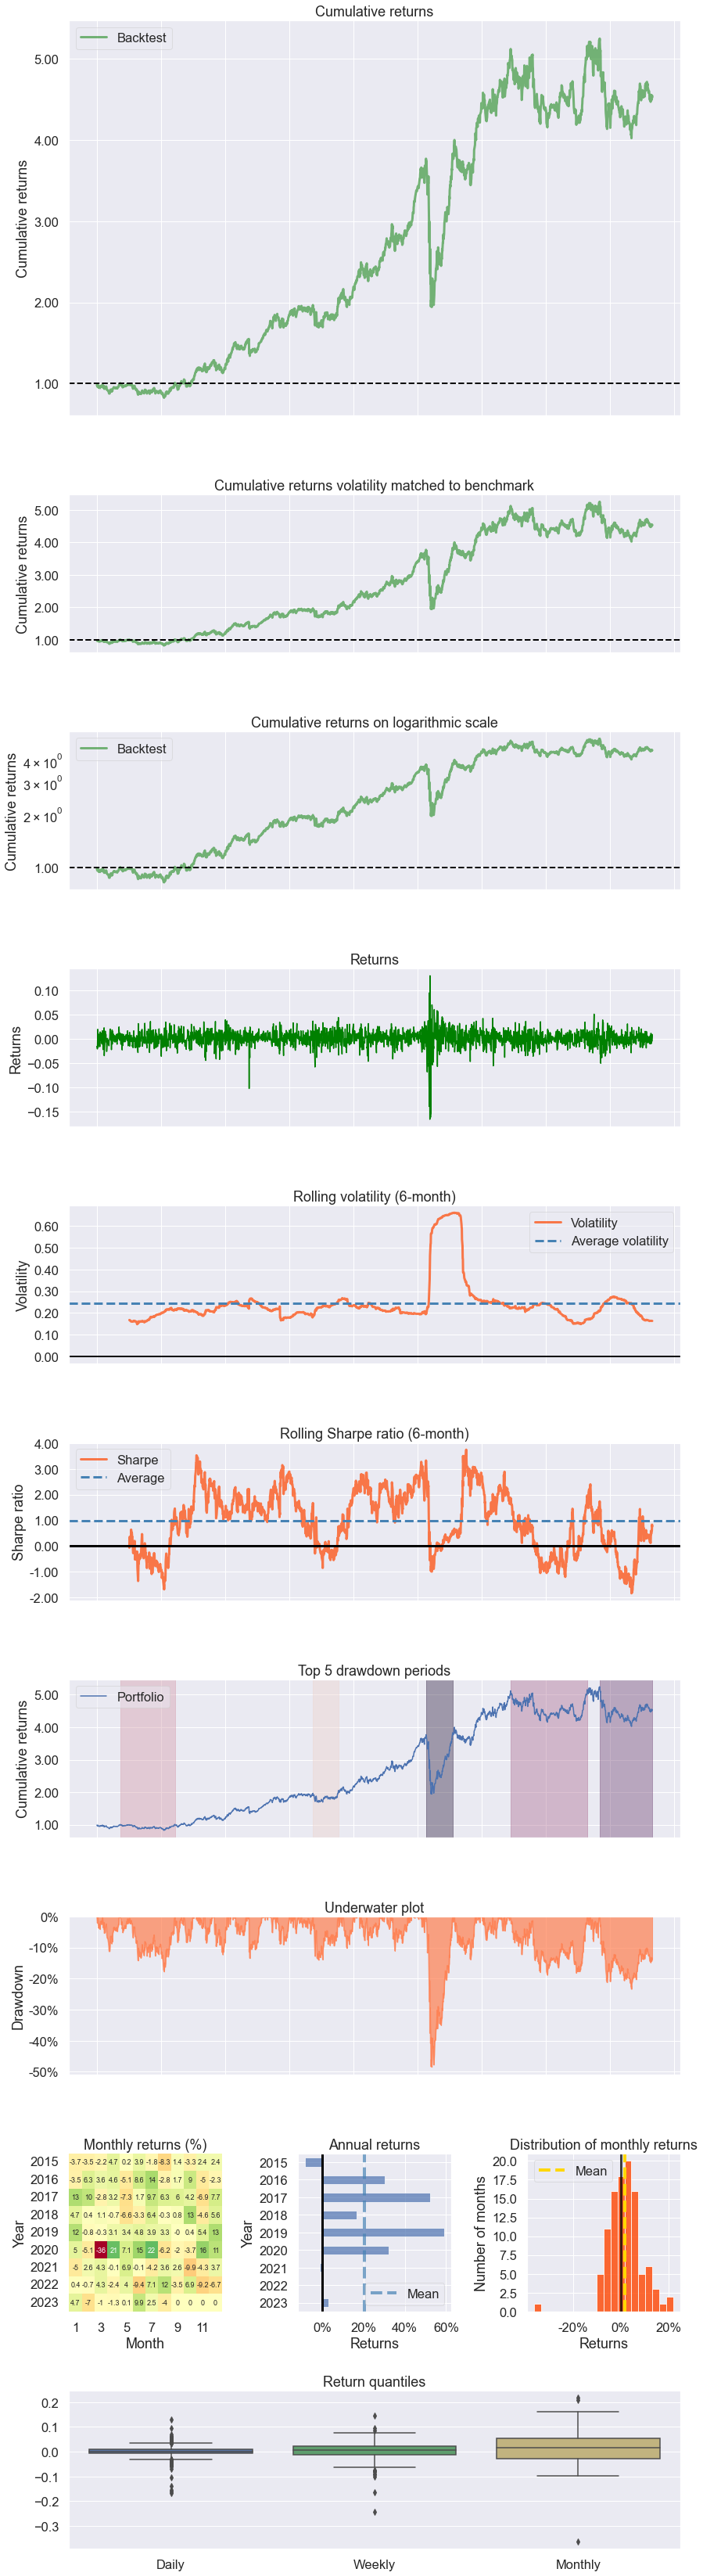

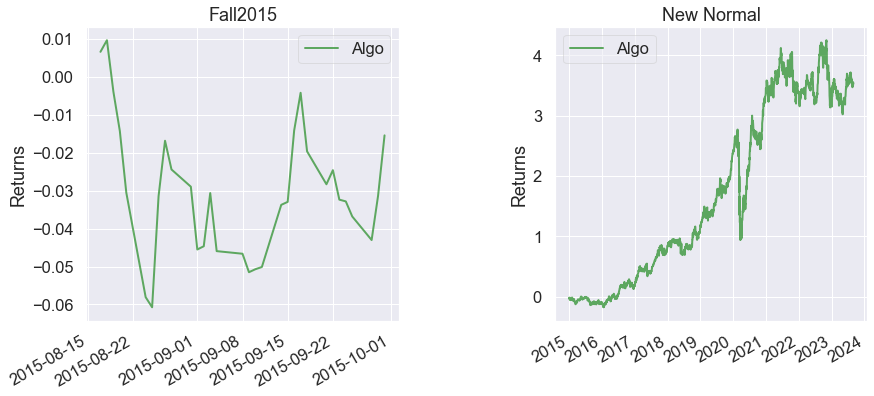

In [13]:
#Não estou conseguindo funcionar com benchmarks, vou deixar comentado

#pf.create_full_tear_sheet(strategy_return, benchmark_rets=bench_return)
#pf.create_full_tear_sheet(strategy_return, benchmark_rets=naive_return)
#pf.create_full_tear_sheet(strategy_return, benchmark_rets=looser_return)
pf.create_full_tear_sheet(strategy_return)

<Axes: >

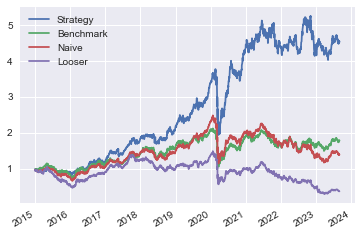

In [14]:
comparative = pd.DataFrame(index=strategy_return.index, \
                           columns=['Strategy', 'Benchmark', 'Naive', 'Looser'])

comparative['Strategy'] = strategy_return
comparative['Benchmark'] = bench_return
comparative['Naive'] = naive_return
comparative['Looser'] = looser_return

(1+comparative).cumprod().plot()

<Axes: >

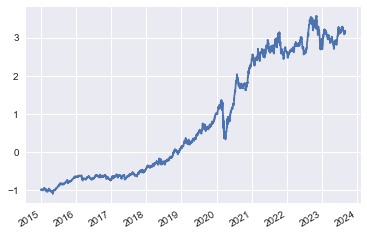

In [15]:
(((1+comparative).cumprod()['Strategy']-(1+comparative).cumprod()['Looser'])-1).plot()

<Axes: >

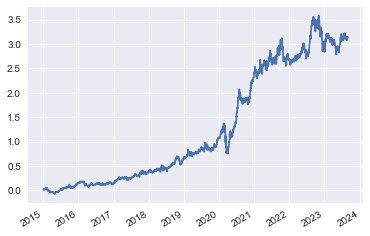

In [16]:
((1+comparative).cumprod()['Strategy']-(1+comparative).cumprod()['Naive']).plot()

<Axes: >

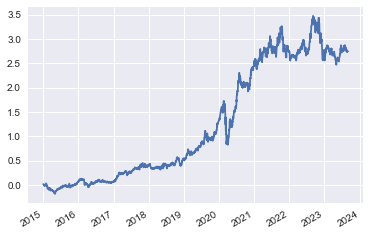

In [17]:
((1+comparative).cumprod()['Strategy']-(1+comparative).cumprod()['Benchmark']).plot()

<Axes: >

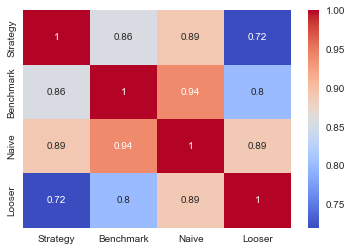

In [18]:
sns.heatmap(comparative.corr(), annot=True, cmap='coolwarm')

In [19]:
comparative['Strategy > Benchmark'] = np.where(comparative['Strategy'] > comparative['Benchmark'], 1, 0)

print('A estratégia superou o benchmark', \
      round((comparative['Strategy > Benchmark'].sum()/len(comparative))*100, 2),'% dos dias')

comparative.drop('Strategy > Benchmark', axis=1, inplace=True)

A estratégia superou o benchmark 51.74 % dos dias


<Axes: xlabel='Strategy', ylabel='Density'>

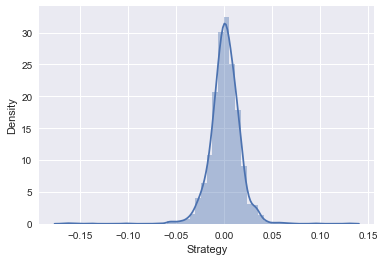

In [20]:
sns.distplot(comparative['Strategy'])

<Axes: xlabel='Benchmark', ylabel='Density'>

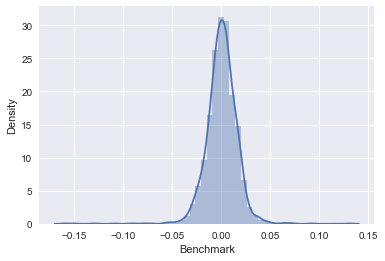

In [21]:
sns.distplot(comparative['Benchmark'])

<Axes: xlabel='Naive', ylabel='Density'>

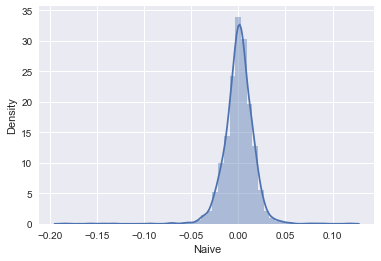

In [22]:
sns.distplot(comparative['Naive'])

<Axes: xlabel='Strategy'>

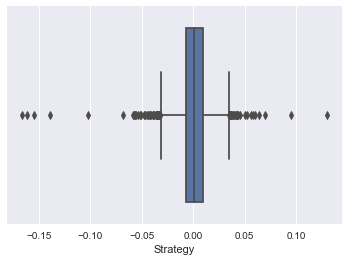

In [23]:
sns.boxplot(x = 'Strategy', data = comparative)

<Axes: xlabel='Benchmark'>

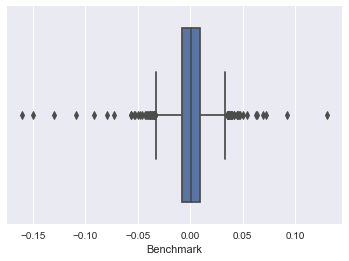

In [24]:
sns.boxplot(x = 'Benchmark', data = comparative)

<Axes: xlabel='Naive'>

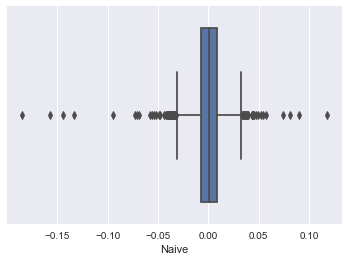

In [25]:
sns.boxplot(x = 'Naive', data = comparative)

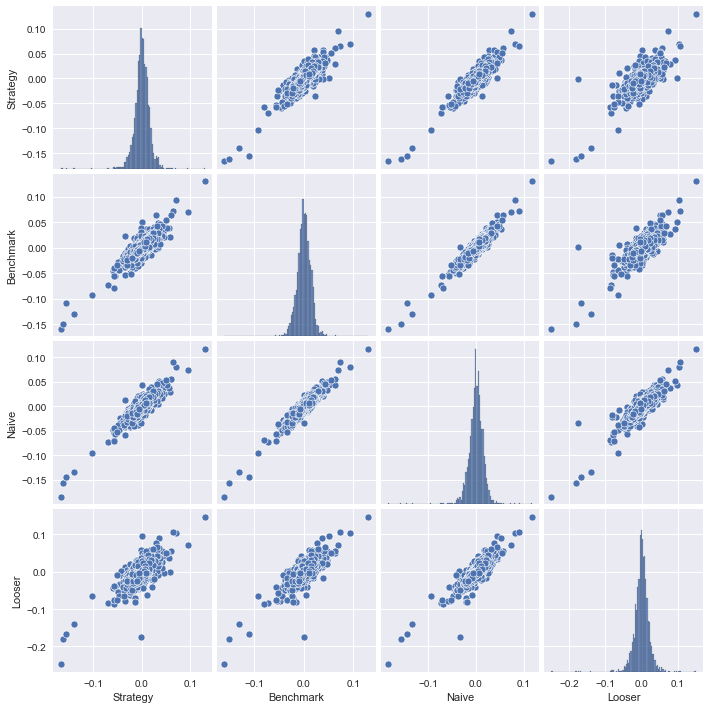

In [26]:
sns.pairplot(comparative)

In [27]:
comparative['Month'] = pd.Series(str)
for i in comparative.index:
    if i.month<10:
        comparative.loc[i,'Month'] = str(i.year)+'-0'+str(i.month)
    else:
        comparative.loc[i,'Month'] = str(i.year)+'-'+str(i.month)
    
comparative

,Strategy,Benchmark,Naive,Looser,Month
2015-01-02,-0.015798,-0.030352,-0.026354,-0.034453,2015-01
2015-01-05,-0.021122,-0.020724,-0.030068,-0.031085,2015-01
2015-01-06,0.004812,0.010134,-0.000333,0.006979,2015-01
2015-01-07,0.019447,0.030003,0.018911,0.016632,2015-01
2015-01-08,-0.005724,0.009657,0.006513,0.015587,2015-01
...,...,...,...,...,...
2023-08-24,-0.004986,-0.009432,-0.009096,-0.017803,2023-08
2023-08-25,-0.009672,-0.010212,-0.015838,-0.024473,2023-08
2023-08-28,0.004175,0.011024,0.003690,0.002494,2023-08
2023-08-29,0.009010,0.010895,0.006560,-0.003581,2023-08


In [28]:
comparative_month = comparative.copy()

comparative_month.loc[:,'Strategy'] = comparative_month.loc[:,'Strategy'] + 1
comparative_month.loc[:,'Benchmark'] = comparative_month.loc[:,'Benchmark'] + 1
comparative_month.loc[:,'Naive'] = comparative_month.loc[:,'Naive'] + 1

comparative_month = comparative_month.groupby('Month').prod() - 1 
comparative_month

,Strategy,Benchmark,Naive,Looser
Month,,,,
2015-01,-0.036508,-0.064816,-0.091568,-1.0
2015-02,-0.035169,0.097977,0.051525,-1.0
2015-03,-0.022197,-0.010656,-0.008074,-1.0
2015-04,0.047420,0.097617,0.064399,-1.0
2015-05,0.002211,-0.063062,-0.021184,-1.0
...,...,...,...,...
2023-04,-0.013213,0.023562,0.027039,-1.0
2023-05,0.000850,0.036080,0.090096,-1.0
2023-06,0.099263,0.088764,0.086081,-1.0


<Axes: xlabel='Strategy', ylabel='Density'>

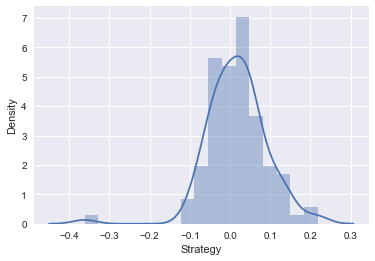

In [29]:
sns.distplot(comparative_month['Strategy'])

<Axes: xlabel='Benchmark', ylabel='Density'>

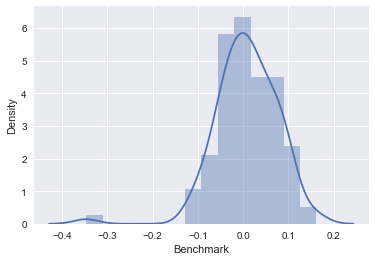

In [30]:
sns.distplot(comparative_month['Benchmark'])

<Axes: xlabel='Naive', ylabel='Density'>

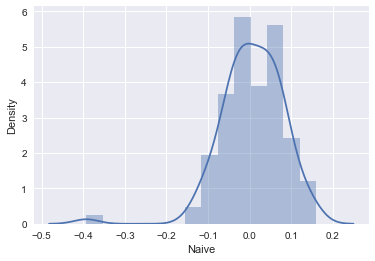

In [31]:
sns.distplot(comparative_month['Naive'])

<Axes: xlabel='Strategy'>

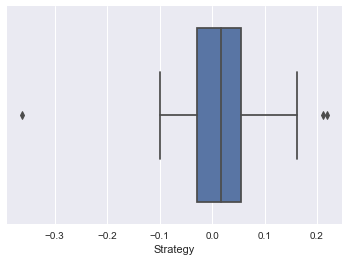

In [32]:
sns.boxplot(x = 'Strategy', data = comparative_month)

<Axes: xlabel='Benchmark'>

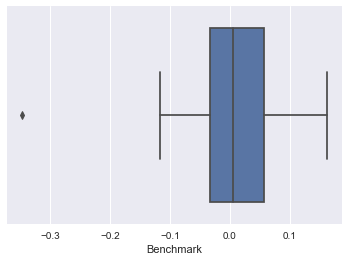

In [33]:
sns.boxplot(x = 'Benchmark', data = comparative_month)

<Axes: xlabel='Naive'>

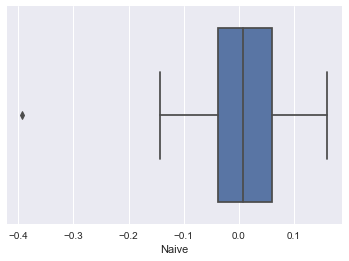

In [34]:
sns.boxplot(x = 'Naive', data = comparative_month)

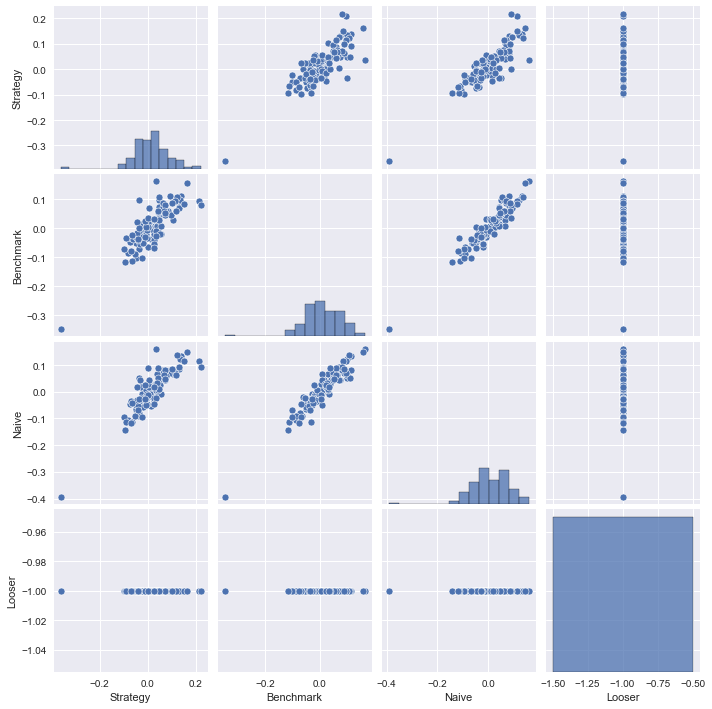

In [35]:
sns.pairplot(comparative_month)